In [1]:
import os

import matplotlib              as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot       as plt
import matplotlib.ticker       as mticker

import numpy                   as np

import radical.analytics       as ra
import radical.pilot           as rp
import radical.utils           as ru

from radical.analytics.utils import to_latex

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!rm -rf ~/.radical/analytics/cache

fonts_dir = os.path.join(os.getcwd(), 'fonts')
# see: https://github.com/radical-cybertools/tutorials/tree/main/src/devel

if os.path.isdir(fonts_dir):
    try:
        fm.fontManager.addfont(fm.findSystemFonts(fonts_dir)[0])

        plt.style.use(ra.get_mplstyle('radical_mpl'))
        mpl.rcParams['text.usetex'] = False
        mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']
        mpl.rcParams['font.family'] = 'serif'
    except Exception as e:
        print(f'WARNING: font is not set ({e})')
else:
    print('WARNING: directory with font(s) not found')

# Get session tracing events

Enter session ID to collect its events:

In [4]:
sid = 're.session.cuda004.amarel.rutgers.edu.ja961.019808.0008' #'<RCT_SESSION_ID>'

In [5]:
session = ra.Session(sid, 'radical.pilot')

In [6]:
data = {'session': session,
        'pilot'  : session.filter(etype='pilot', inplace=False).get()[0],
        'tasks'  : session.filter(etype='task',  inplace=False)}

data['sid'] = sid
data['pid'] = data['pilot'].uid
data['smt'] = os.environ.get('RADICAL_SMT') or \
              data['pilot'].cfg['resource_details']['rm_info']['threads_per_core']

In [7]:
def run_metrics(data, ntasks=None):
    ttx = data['tasks'].duration(event=[{ru.EVENT: 'task_run_start'},
                                        {ru.EVENT: 'task_run_stop'}])
    runtime = data['pilot'].duration(event=[{ru.EVENT: 'bootstrap_0_start'},
                                            {ru.EVENT: 'bootstrap_0_stop'}])
    print(f'TOTAL RUNTIME: {round(runtime)}s | RCT OVH: {round(runtime - ttx)}s')
    
    if ntasks and ntasks > 1:
        task_idx = ntasks - 1
        print(f'# Following rates are based on the first {ntasks} tasks')
    else:
        task_idx = -1
        ntasks = None
        print(f'# Following rates are based on all tasks')

    # calculate scheduling throughput (for the first N tasks or for all tasks)
    ts_schedule_ok = sorted(session.timestamps(event={ru.STATE: 'AGENT_SCHEDULING'}))
    total_tasks = ntasks or len(ts_schedule_ok)
    print('scheduling rate: ', total_tasks / (ts_schedule_ok[task_idx] - ts_schedule_ok[0]))

    # calculate launching rate (for the first N tasks or for all tasks)
    ts_agent_executing = sorted(session.timestamps(event=[{ru.EVENT: 'launch_submit'}]))
    total_tasks = ntasks or len(ts_agent_executing)
    print('launching rate: ', total_tasks / (ts_agent_executing[task_idx] - ts_agent_executing[0]))

In [8]:
try:
    run_metrics(data, ntasks=None)
except Exception as e:
    print(e)

TOTAL RUNTIME: 67623s | RCT OVH: 98s
# Following rates are based on all tasks
scheduling rate:  0.0005956616681805286
launching rate:  0.0005956623079569446


# Resource Utilization

In [9]:
def plot_utilization(data, resources=None, save=True, with_metrics=False):

    DURATIONS = {
        'boot'        : [{ru.EVENT: 'bootstrap_0_start'},
                         {ru.EVENT: 'bootstrap_0_ok'   }],
        'agent_setup' : [{ru.EVENT: 'bootstrap_0_ok'   },
                         {ru.STATE: rp.PMGR_ACTIVE     }],
        'exec_queue'  : [{ru.STATE: rp.AGENT_SCHEDULING},
                         {ru.STATE: rp.AGENT_EXECUTING }],
        'exec_prep'   : [{ru.STATE: rp.AGENT_EXECUTING },
                         {ru.EVENT: 'task_run_start'   }],
        'exec_rp'     : [{ru.EVENT: 'task_run_start'   },
                         {ru.EVENT: 'launch_start'     }],
        'exec_sh'     : [{ru.EVENT: 'launch_start'     },
                         {ru.EVENT: 'launch_submit'    }],
        'exec_launch' : [{ru.EVENT: 'launch_submit'    },
                         {ru.EVENT: 'exec_start'       }],
        'exec_cmd'    : [{ru.EVENT: 'exec_start'       },
                         {ru.EVENT: 'exec_stop'        }],
        'exec_finish' : [{ru.EVENT: 'exec_stop'        },
                         {ru.EVENT: 'launch_collect'   }],
        'term_sh'     : [{ru.EVENT: 'launch_collect'   },
                         {ru.EVENT: 'launch_stop'      }],
        'term_rp'     : [{ru.EVENT: 'launch_stop'      },
                         {ru.EVENT: 'task_run_stop'    }],
        'unschedule'  : [{ru.EVENT: 'task_run_stop'    },
                         {ru.EVENT: 'unschedule_stop'  }]
    }

    METRICS = [
        ['Bootstrap',     ['boot', 'agent_setup'],        '#c6dbef'],
        #['Warmup',        ['warm'],                       '#f0f0f0'],
        ['Schedule',      ['exec_queue', 'unschedule'],   '#c994c7'],
        ['Prep',          ['exec_prep', 'exec_rp', 'exec_sh',
                           'term_sh', 'term_rp'],         '#fdbb84'],
        #['Launch method', ['exec_launch', 'exec_finish'], '#ff9999'],
        ['Launch',        ['exec_launch'],                '#ff9999'],
        ['Running',       ['exec_cmd'],                   '#88bb88'],  # color to be updated
        #['Cooldown',      ['drain'],                      '#addd8e']
    ]
    
    correction = 0.5
    sid = data['sid']
    pid = data['pid']
    
    rtypes = ru.as_list(resources) or ['cpu', 'gpu']
    rtype_info = {'cpu': {'label': 'Number of CPU cores',
                          'formatter': lambda z, pos: int(z / data['smt'])},
                  'gpu': {'label': 'Number of GPUs',
                          'formatter': None}}
    
    # fig, axarr = plt.subplots(1, len(rtypes), figsize=(
    #     ra.get_plotsize(256 * len(rtypes), subplots=(1, len(rtypes)))))
    fig, axarr = plt.subplots(len(rtypes), 1, figsize=(7, 2 * len(rtypes)))
    
    exp = ra.Experiment([data['session']], stype='radical.pilot')
    # get the start time of each pilot
    p_zeros = ra.get_pilots_zeros(exp)
    
    # --- filter tasks per pipeline and color state RUNNING per pipeline ---
    
    p_tasks = {}  # tasks per pipeline
    for task in data['tasks'].get():
        t_name_parts = task.description['name'].split(',')
        pipeline_uid = '' if len(t_name_parts) < 5 else t_name_parts[4]
        p_tasks.setdefault(pipeline_uid, []).append(task.uid)

    M_COLOR_RUNNING = ['#88bb88', '#669d66', '#557a55', '#475f47']  # green color with darker shades
    if len(p_tasks) > len(M_COLOR_RUNNING):
        raise RuntimeError('Not enough colors for available pipelines')

    # --- ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ---

    legend = None
    for idx, rtype in enumerate(rtypes):
        
        if len(rtypes) > 1:
            ax = axarr[idx]
        else:
            ax = axarr
        
        x_min, x_max, y_min, y_max = None, None, None, None
        for idx, (p_uid, task_uids) in enumerate(p_tasks.items()):
            p_session = data['session'].filter(uid=task_uids + [pid], inplace=False)

            consumed = rp.utils.get_consumed_resources(
                p_session, rtype, {'consume': DURATIONS})

            METRICS[-1][-1] = M_COLOR_RUNNING[idx]
            # generate the subplot with labels
            legend, patches, x, y = ra.get_plot_utilization(
                METRICS, {sid: consumed}, p_zeros[sid][pid], sid)

            # place all the patches, one for each metric, on the axes
            for patch in patches:
                patch.set_y(patch.get_y() + correction)
                ax.add_patch(patch)
            
            x_min = x['min'] if not x_min else min(x_min, x['min'])
            x_max = x['max'] if not x_max else max(x_max, x['max'])
            y_min = y['min'] if not y_min else min(y_min, y['min'])
            y_max = y['max'] if not y_max else max(y_max, y['max'])

        ax.set_xlim([x_min, int(x_max)])
        ax.set_ylim([y_min + correction, int(y_max + correction)])

        ax.xaxis.set_major_locator(mticker.MaxNLocator(4))
        ax.yaxis.set_major_locator(mticker.MaxNLocator(4))

        if rtype_info[rtype]['formatter'] is not None:
            ax.yaxis.set_major_formatter(mticker.FuncFormatter(
                rtype_info[rtype]['formatter']))

        ax.set_ylabel(to_latex(rtype_info[rtype]['label']), fontsize=11)
        ax.set_title(' ')  # placeholder

    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)

    fig.legend(legend, [m[0] for m in METRICS],
               loc='upper center',
               #bbox_to_anchor=(0.5, 0.95),
               ncol=len(METRICS)) 
    
    plt.tight_layout()
    plt.show()
    
    plot_name = '%s.ru.png' % '.'.join(sid.rsplit('.', 2)[1:])
    fig.savefig(plot_name)
    
    if with_metrics:
        # print resource utilization metrics
        for rtype in rtypes:
            _, _, stats_abs, stats_rel, info = data['session'].utilization(
                METRICS, rtype, {'consume': DURATIONS})
            print('%s RU: ' % rtype.upper(), info)

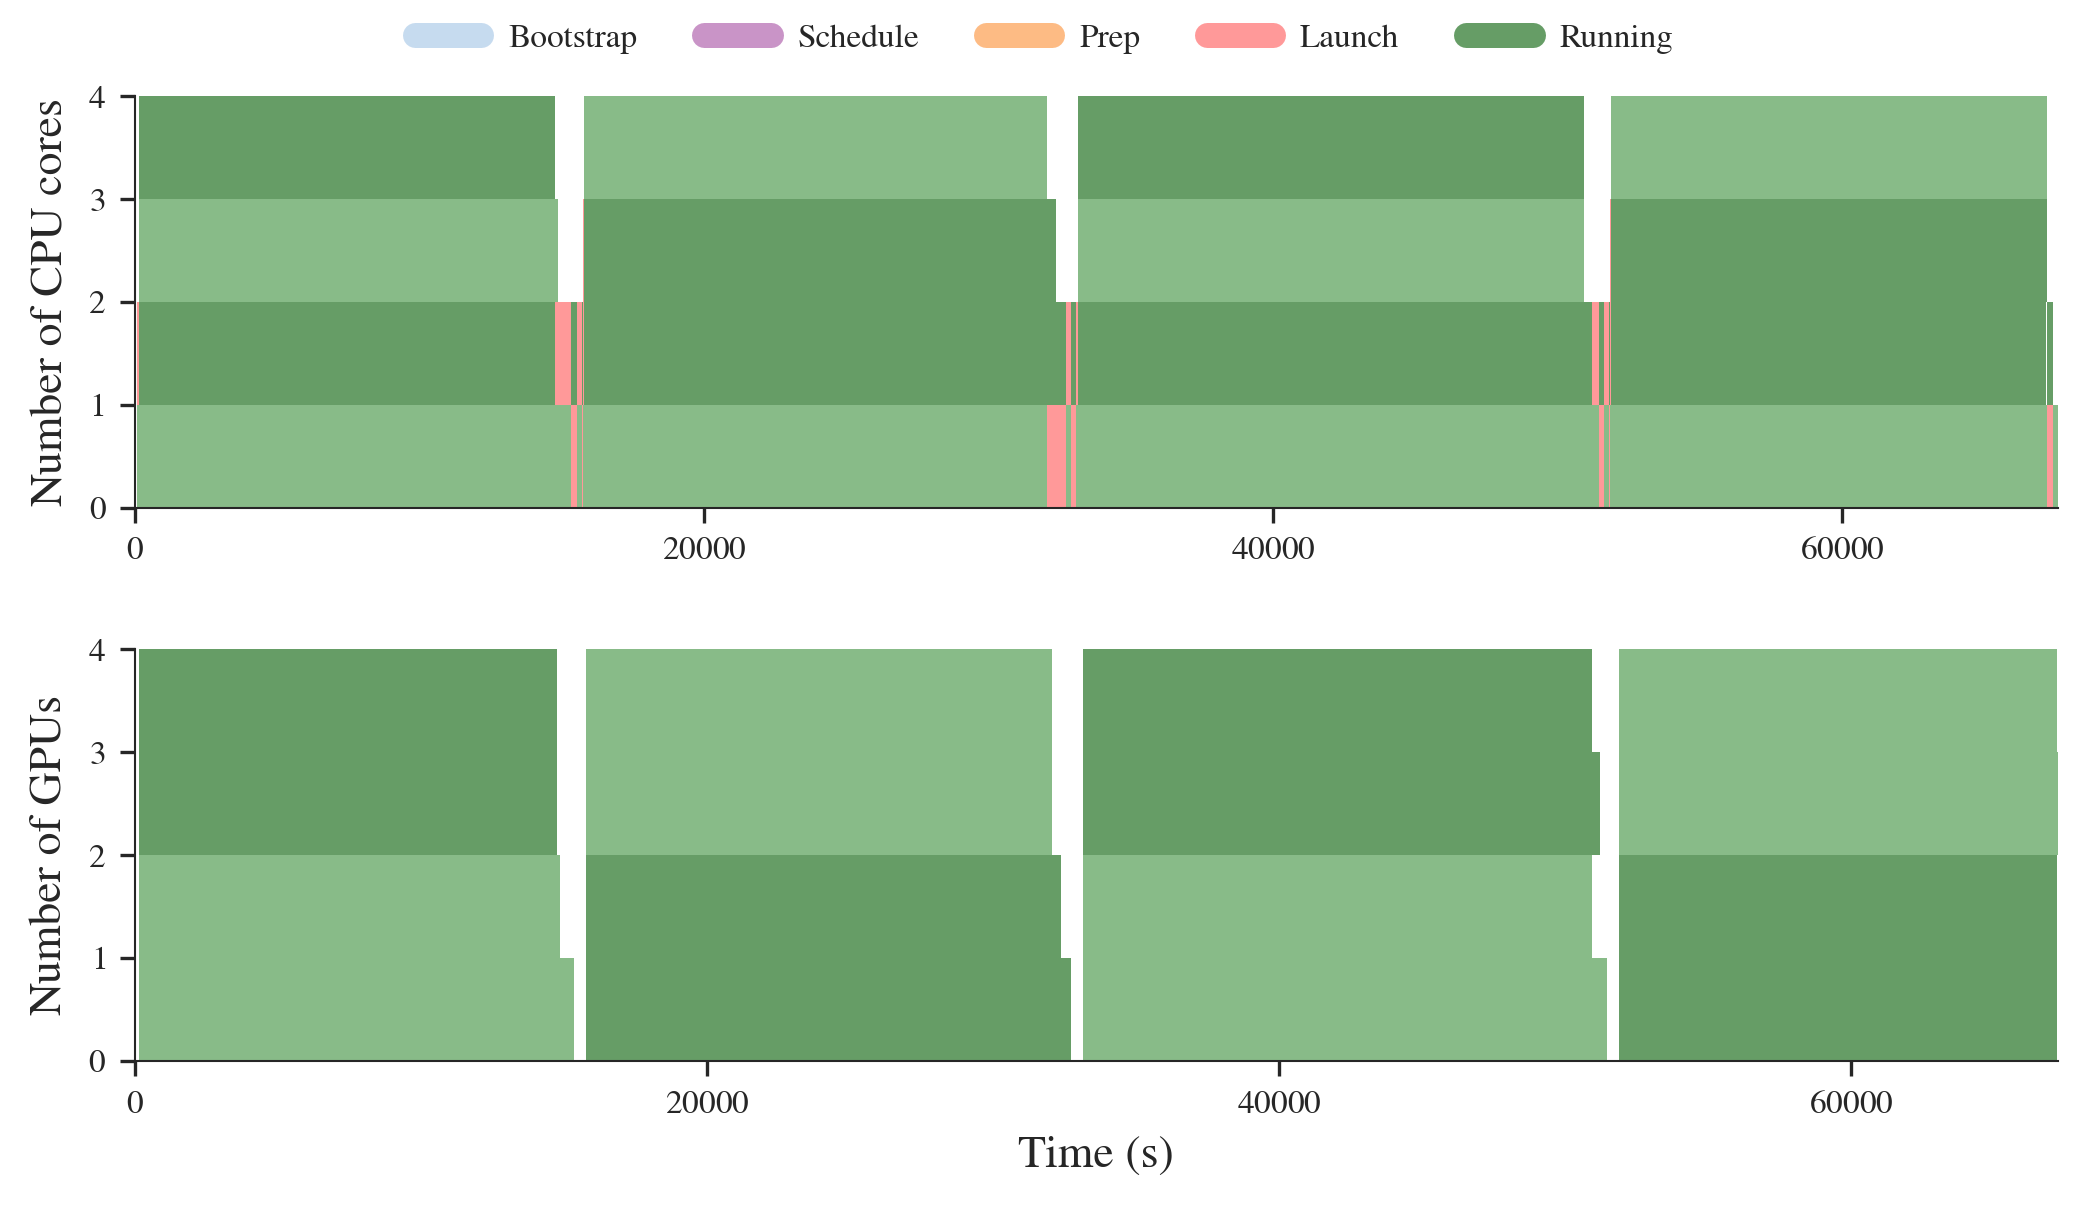

In [10]:
plot_utilization(data, resources=['cpu', 'gpu'], save=True, with_metrics=False)

# Resource Utilization - STACKED

In [11]:
def plot_utilization_stack(data, resources=None, save=True):

    tmap = {
        'pilot':  [
            [{1: 'bootstrap_0_start'}     , 'system'     , 'Bootstrap'  ],
            [{5: 'PMGR_ACTIVE'}           , 'Bootstrap'  , 'Idle'       ],
            [{1: 'cmd', 6: 'cancel_pilot'}, 'Idle'       , 'Term'       ],
            [{1: 'bootstrap_0_stop'}      , 'Term'       , 'system'     ],
            [{1: 'sub_agent_start'}       , 'Idle'       , 'agent'      ],
            [{1: 'sub_agent_stop'}        , 'agent'      , 'Term'       ]
        ],
        'task': [
            [{1: 'schedule_ok'}           , 'Idle'       , 'Exec setup' ],
            [{1: 'exec_start'}            , 'Exec setup' , 'Running'    ],
            [{1: 'exec_stop'}             , 'Running'    , 'Exec setup' ],
            [{1: 'unschedule_stop'}       , 'Exec setup' , 'Idle'       ]
        ],
    }
    metrics = [ 
        # metric,      line color, alpha, fill color, alpha
        ['Bootstrap',  ['#c6dbef', 0.0, '#c6dbef', 1]],
        ['Exec setup', ['#fdbb84', 0.0, '#fdbb84', 1]],
        ['Running',    ['#88bb88', 0.0, '#88bb88', 1]],
        ['Idle',       ['#f0f0f0', 0.0, '#f0f0f0', 1]]
    ]

    to_stack = [m[0] for m in metrics]
    to_plot = {m[0]: m[1] for m in metrics}
    
    sid = data['sid']
    pid = data['pid']
    
    rtypes = ru.as_list(resources) or ['cpu', 'gpu']
    fig, axarr = plt.subplots(len(rtypes), 1, figsize=(7, 2 * len(rtypes)))

    patches = []
    legend = []

    p_resrc, series, x = ra.get_pilot_series(
        data['session'], data['pilot'], tmap, rtypes, True)

    for idx, rtype in enumerate(rtypes):
        
        if len(rtypes) > 1:
            ax = axarr[idx]
        else:
            ax = axarr

        # stack timeseries for each metrics into areas
        areas = ra.stack_transitions(series, rtype, to_stack)

        # plot individual metrics
        prev_m = None
        for m in areas:

            if m not in to_plot:
                if m != 'time':
                    print('skip', m)
                continue

            lcol = to_plot[m][0]
            lalpha = to_plot[m][1]
            pcol = to_plot[m][2]
            palpha = to_plot[m][3]

            # plot the (stacked) areas
            ax.step(np.array(areas['time']), np.array(areas[m]),
                    where='post', label=m,
                    color=lcol, alpha=lalpha, linewidth=1.0)

            # fill first metric toward 0, all others towards previous line
            if not prev_m:
                patch = ax.fill_between(
                    areas['time'], areas[m],
                    step='post', label=m,
                    linewidth=0.0,
                    color=pcol, alpha=palpha)

            else:
                patch = ax.fill_between(
                    areas['time'], areas[m],
                    areas[prev_m],
                    step='post', label=m,
                    linewidth=0.0,
                    color=pcol, alpha=palpha)

            # remember patches for legend
            if len(legend) < len(metrics):
                legend.append(m)
                patches.append(patch)

            # remember this line to fill against
            prev_m = m

        ax.set_xlim([x['min'], x['max']])
        ax.set_ylim([0, 110])

        ax.yaxis.set_major_locator(
            mticker.MaxNLocator(3, steps=[5, 10]))

        ax.set_ylabel('%s (%%)' % rtype.upper(), fontsize=12)

        for ax in fig.get_axes():
            ax.label_outer()

    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)

    fig.legend(patches, legend, 
               loc='upper center',
               #bbox_to_anchor=(0.5, 1.01),
               ncol=len(metrics),
               fancybox=True, shadow=True, fontsize=11)

    plt.tight_layout()
    plt.show()

    if save:
        plot_name = '%s.ru.stack.png' % '.'.join(sid.rsplit('.', 2)[1:])
        fig.savefig(os.path.join('.', plot_name))

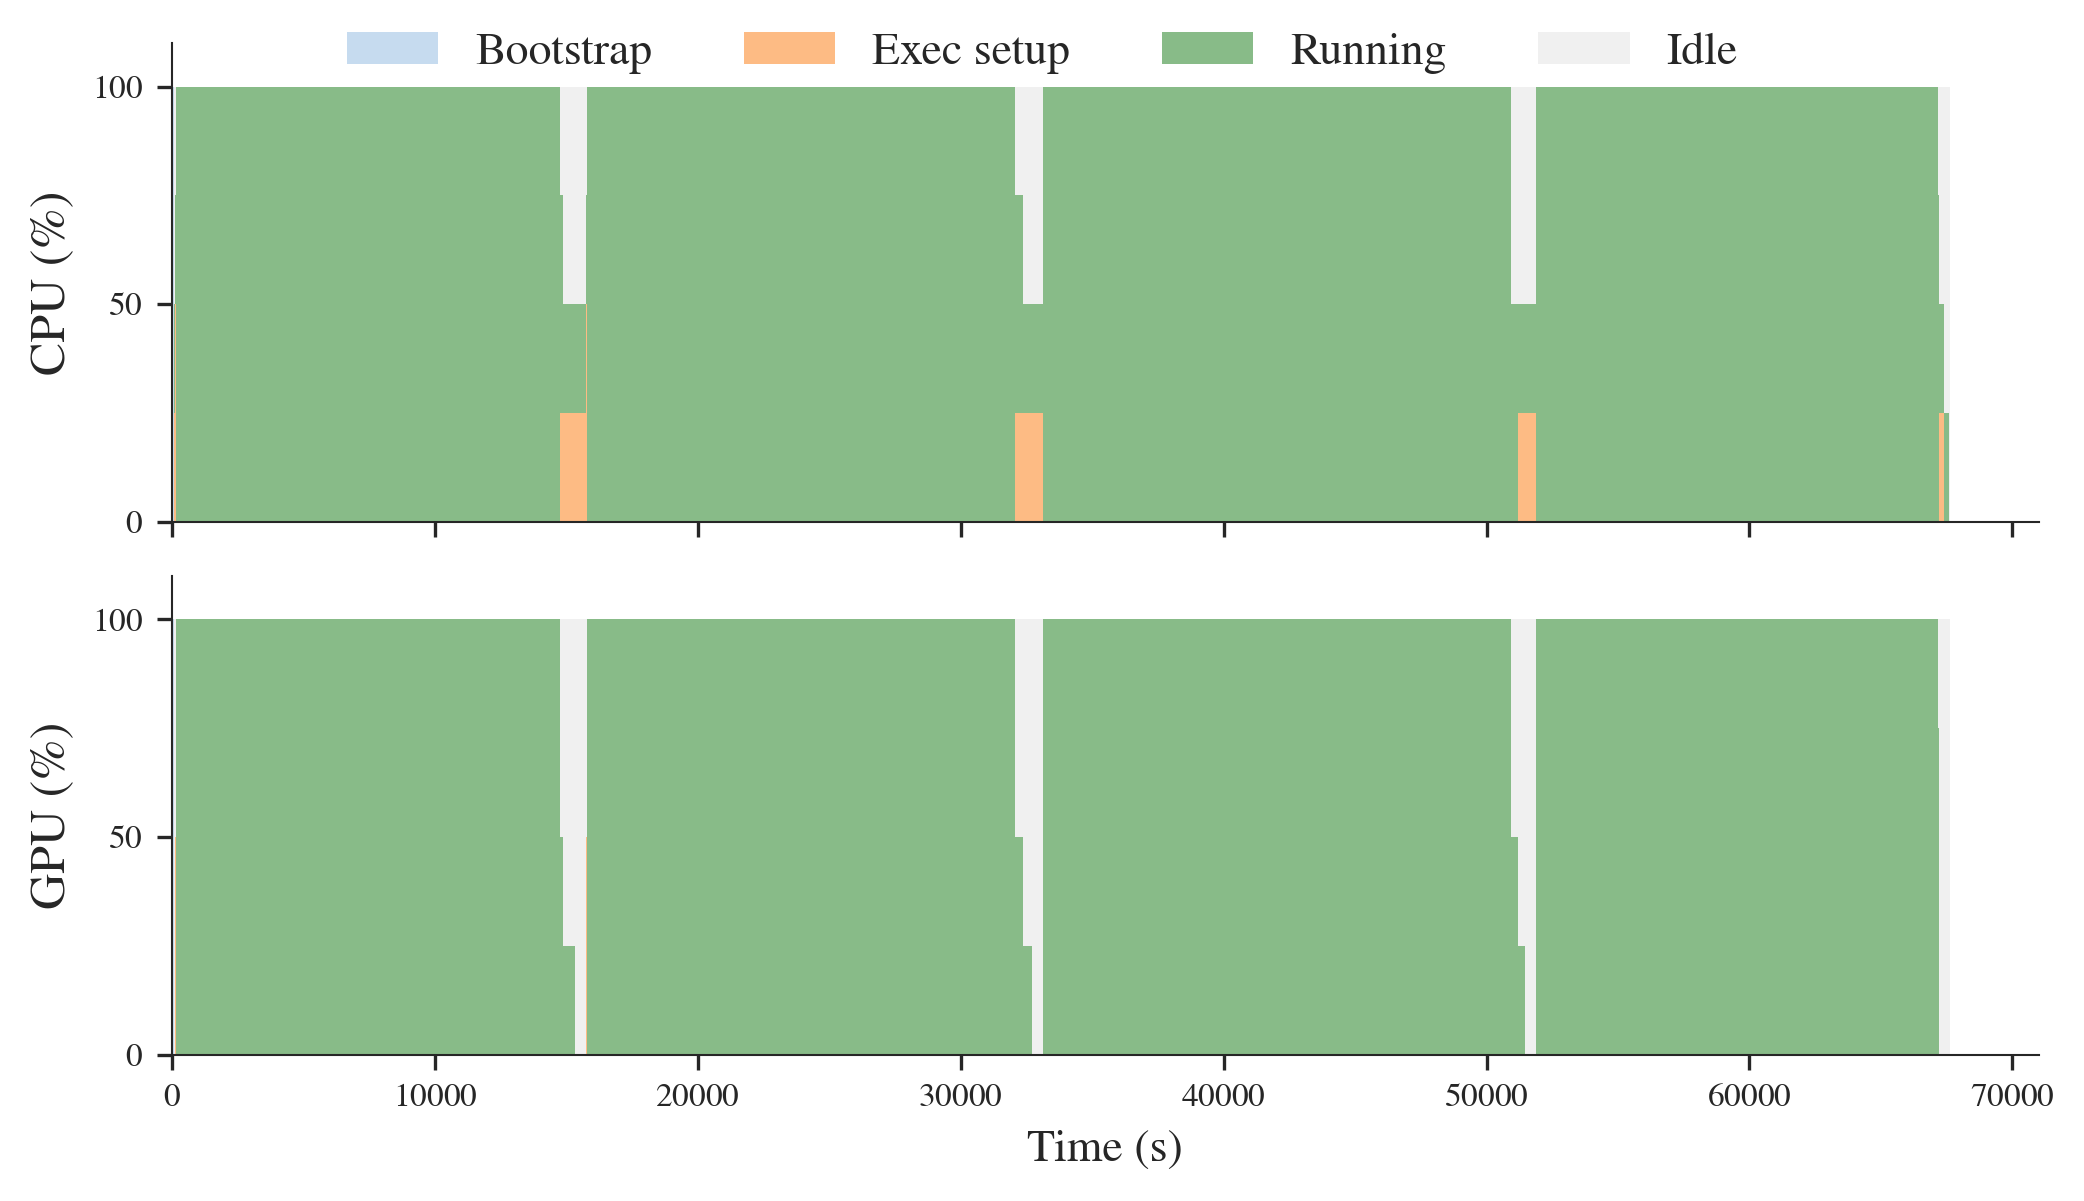

In [12]:
plot_utilization_stack(data, resources=['cpu', 'gpu'], save=True)

# Concurrency
Number of tasks within a certain phase during a runtime period.

In [13]:
def plot_concurrency(data, save=True):

    events = {'Tasks scheduling': [{ru.STATE: 'AGENT_SCHEDULING'},
                                   {ru.EVENT: 'schedule_ok'}],
              'Tasks running'   : [{ru.EVENT: 'exec_start'},
                                   {ru.EVENT: 'exec_stop'}]}

    # events = {'Tasks placed'   : [{ru.EVENT: 'launch_submit'},
    #                               {ru.EVENT: 'launch_collect'}]}
    # events = {'Job steps launched': [{ru.EVENT: 'launch_submit'},
    #                                  {ru.EVENT: 'exec_start'}]}

    fig, ax = plt.subplots(1, 1, figsize=(7, 2))

    pilot_starttime = data['pilot'].\
        timestamps(event={ru.EVENT: 'bootstrap_0_start'})[0]

    legend = []
    for e_name in events:
        time_series = data['session'].concurrency(event=events[e_name], sampling=0.1)
        ax.plot([e[0] - pilot_starttime for e in time_series],
                [e[1] for e in time_series],
                label=ra.to_latex(e_name), lw=1)
        legend.append(e_name)

    ax.set_ylabel(to_latex('Number of tasks'), fontsize=11)
    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)
        
    fig.legend(legend,
               loc='upper center',
               bbox_to_anchor=(0.75, 1.05),
               ncol=len(legend), 
               fontsize=11)

    plt.tight_layout()
    plt.show()

    if save:
        plot_name = '%s.concurrency.png' % '.'.join(data['sid'].rsplit('.', 2)[1:])
        fig.savefig(os.path.join('.', plot_name))

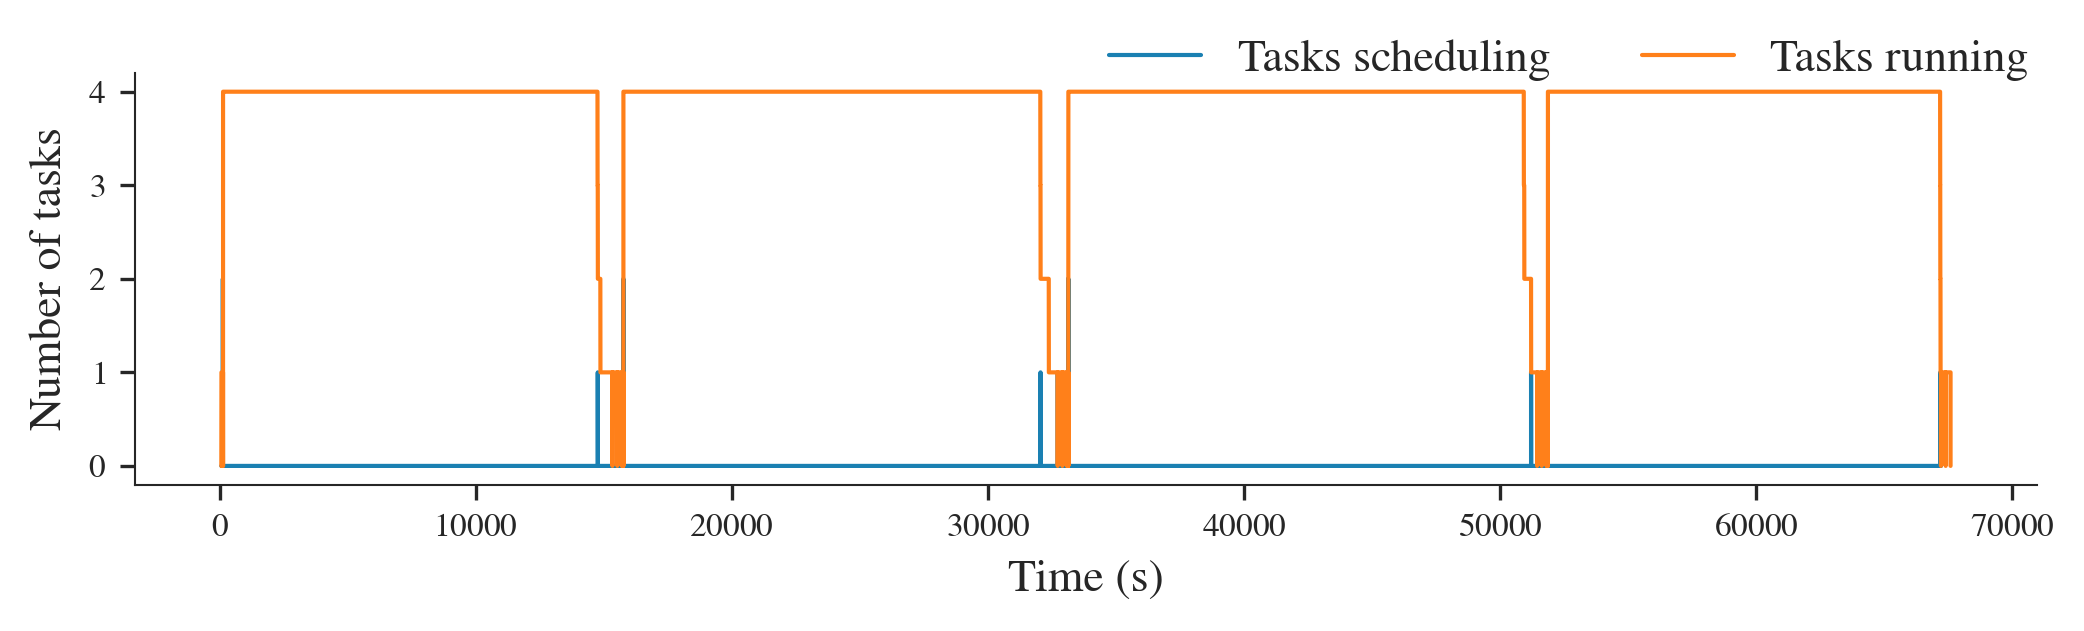

In [14]:
plot_concurrency(data, save=True)